In [47]:
# joblib.dump(model, 'model_14_12_10_59.pkl')
# model = joblib.load('model.pkl')

['model_14_12_10_59.pkl']

In [1]:
from codes import *

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [4]:
prepareCorpus(tolower=True, _stemming=False, _lemmatizing=True, dataFolder='./data/', max_features=5000)

Reading data
Building corpus
Tokenize


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Merging
Saving Tfidf model
Done


In [ ]:
df = joblib.load('./data/TfidfDataframe.pkl')

In [ ]:
X = np.array(df['tfidf'])
y = np.array(df['is_duplicate'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def data_generator(X, y, batch_size, epochs):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    for epoch in range(epochs):
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, num_samples)
    
            batch_indices = np.arange(start_idx, end_idx)
            X_batch_sparse = X[batch_indices]
            X_batch_dense = np.vstack([convert_to_dense(x) for x in X_batch_sparse])
            y_batch = y[batch_indices]
            
            yield X_batch_dense, y_batch

def convert_to_dense(sparse_vector):
    return sparse_vector.toarray().flatten()

In [ ]:
model = Sequential()
model.add(Dense(units=1024, input_dim=10000, activation='relu'))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 1024
epochs = 20

train_generator = data_generator(X_train, y_train, batch_size, epochs)
validation_generator = data_generator(X_test, y_test, batch_size, epochs)

steps_per_epoch = int(np.ceil(X_train.shape[0] / batch_size))
validation_steps = int(np.ceil(X_test.shape[0] / batch_size))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data=validation_generator, validation_steps=validation_steps, callbacks=[early_stopping])

Epoch 1/20
230/316 [====================>.........] - ETA: 40s - loss: 0.5136 - accuracy: 0.7493

KeyboardInterrupt: 

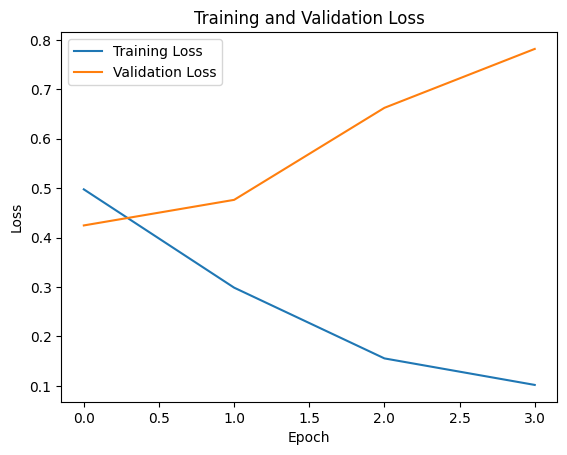

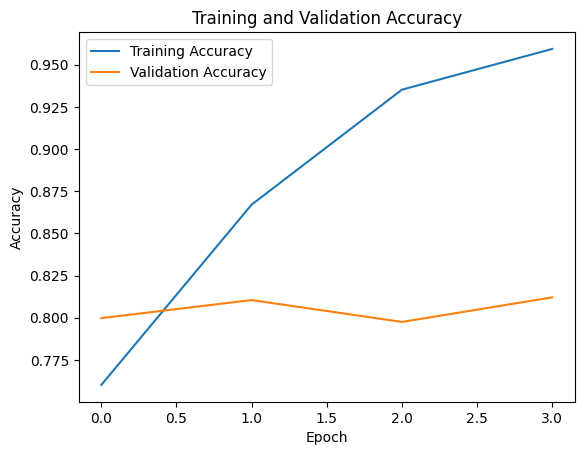

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

79/79 [==============================] - 12s 149ms/step
Accuracy: 0.7997477058547082
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85     50803
           1       0.78      0.65      0.71     30055

    accuracy                           0.80     80858
   macro avg       0.79      0.77      0.78     80858
weighted avg       0.80      0.80      0.80     80858



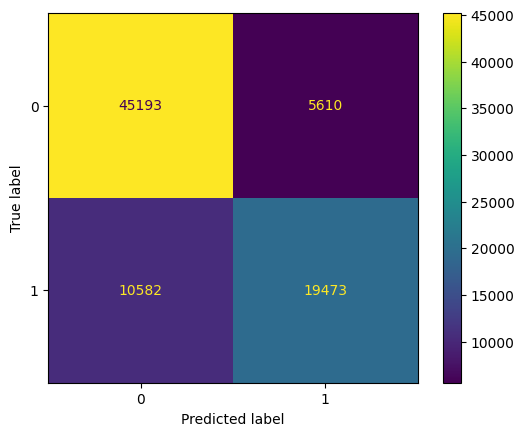

In [ ]:
validation_generator = data_generator(X_test, y_test, batch_size, epochs)
y_pred_prob = model.predict(validation_generator, steps=validation_steps)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()